## Test the effect of fill forward NaNs

In [121]:
import random
import wandb
import torch
from transformers.utils import logging
random_seed =23
random.seed(random_seed)
## TODO: save indexes of which shots were training and test
#       -- see if the trainer saves the train and test datasets  
## TODO: code feedforward NaN evaluation strategy (using test shots)

### Load test dataset

In [94]:
import data_processing
from data_processing import ModelReadyDataset, train_test_split
data = data_processing.load_data("Full_HDL_dataset_unnormalized_no_nan.pickle")

In [95]:
train, test = train_test_split(
    data, 
    end_cutoff=.8, 
    machine_hyperparameters={"cmod":1.0, "d3d":1.0, "east":1.0},
    train_size=.97)

#### Load a huggingface transformer model

In [96]:
from transformers import AutoModel, AutoModelForSequenceClassification

In [97]:
run = wandb.init(project="HDL-improvement-transformer", job_type="extract-model", entity="lucas-spangher")
artifact= run.use_artifact("model-vy7ggzg4:v0")

artifact_dir = artifact.download()
model = AutoModelForSequenceClassification.from_pretrained(artifact_dir)

wandb: Downloading large artifact model-vy7ggzg4:v0, 62.73MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:1.9


In [98]:
eval_model = model.eval()
model

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 13)
    (wpe): Embedding(2048, 13)
    (drop): Dropout(p=1e-05, inplace=False)
    (h): ModuleList(
      (0-14): 15 x GPT2Block(
        (ln_1): LayerNorm((13,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.13801574268527766, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((13,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): GELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((13,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=13, out_features=2, bias=False)
)

#### Windowing procedure for adding more nans: params x window length x num_windows

In [187]:
def set_windows_to_fill_nans(
        window_length,
        num_windows,
        num_params,
        inputs_embeds,
        method="ffill",):
    """Set windows to previous value that they were to simulate ffill NaNs
    
    Args:
        window_length (int): length of window
        num_windows (int): number of windows
        num_params (int): number of parameters
        inputs_embeds (torch.tensor): input embeddings
        method (str): method to use to fill NaNs
        
    Returns:
        inputs_embeds (torch.tensor): input embeddings with ffill NaNs"""
    
    # sample random window starts between index 2 and len(inputs_embeds) - window_length
    inputs_embeds = inputs_embeds.clone().detach()
    shot_length, total_params = inputs_embeds.shape
    
    window_starts = random.sample(range(2, shot_length - window_length), k=min(num_windows, shot_length - window_length - 2))
    params = random.sample(range(total_params), k=min(num_params, total_params))

    for start in window_starts:
        for param in params:
            if method == "ffill":
                inputs_embeds[start:start+window_length, param] = inputs_embeds[start-1, param]
            elif method == "noise":
                inputs_embeds[start:start+window_length, param] = torch.randn(window_length)
    
    return inputs_embeds

In [186]:
def extract_metrics(y_true, y_pred):
    """Extract metrics from y_true and y_pred

    Args:
        y_true (int): true label
        y_pred (int): predicted label

    Returns:
        prediction_accuracy (int): 1 if correct, 0 if incorrect
        fnr (int): 1 if false negative, 0 if not
        fpr (int): 1 if false positive, 0 if not
    """
    
    prediction_accuracy = int(y_true == y_pred)
    fnr = int(y_true != y_pred and y_true == 1)
    fpr = int(y_true != y_pred and y_true == 0)

    return prediction_accuracy, fnr, fpr

In [185]:
def predict_from_eval_model(eval_model, inputs, model="transformer"):
    """Predict from eval_model

    Args:
        eval_model (Union[
            transformers.modeling_outputs.SequenceClassifierOutput,
            random_forest_model]): eval model
        inputs (Union[
            torch.tensor, np.array]): input embeddings

    Returns:
        predicted_class: (Union[
            torch.tensor, np.array]): predictions
        logits: Union[torch.tensor, np.array]: model output logits
    """

    if model == "transformer":
        with torch.no_grad():
            outputs = eval_model(inputs_embeds=inputs.unsqueeze(0).type(torch.float16))
        predicted_class = torch.argmax(outputs.logits).tolist()
        logits = outputs.logits

    elif model == "random_forest":
        
        # TODO: Matteo, your code will go here
        raise NotImplementedError
    
    return predicted_class, logits
 

In [188]:
import numpy as np

def predict_on_filled_data(
        eval_model,
        test_shots,
        window_length,
        num_windows,
        num_params,
        method="ffill"):
    """Evaluate model performance on test shots with ffill NaNs.
    
    Args:
        model (Union[
            transformers.modeling_utils.SequenceClassification,
            random_forest]): model to evaluate
        test_shots (list): list of test shots
        window_length (int): length of window
        num_windows (int): number of windows
        num_params (int): number of parameters
        threshold (float): threshold for classification
        method (str): method to use to fill NaNs
    
    Returns:
        prediction_accuracy (float): average prediction accuracy
        fpr (float): average false positive rate
        fnr (float): average false negative rate
        """

    prediction_accuracies = []
    fprs = []
    fnrs = []
    cross_entropy_losses = []

    for i, shot in enumerate(test_shots):
        # print every 100 shots
        if i % 100 == 0:
            print(i)

        inputs_embeds = shot["inputs_embeds"].to(dtype=torch.float16)
        label = shot["labels"].tolist()

        if inputs_embeds.shape[0] < 25:
            continue

        # if window_length is greater than the length of the shot, set to length of shot - 2     
        window_length = min(window_length, inputs_embeds.shape[0] - 3)

        inputs_embeds_naned = set_windows_to_fill_nans(
            window_length=window_length,
            num_windows=num_windows,
            num_params=num_params,
            inputs_embeds=inputs_embeds,
            method=method)
        
        predicted_class, logits = predict_from_eval_model(
            eval_model=eval_model,
            inputs=inputs_embeds_naned,
            model="transformer")
        
        cross_entropy_loss = torch.nn.functional.cross_entropy(
            logits, torch.tensor(label, dtype=torch.long).unsqueeze(0))
        cross_entropy_losses.append(cross_entropy_loss)

        accuracy, fnr, fpr = extract_metrics(label, predicted_class)
        prediction_accuracies.append(accuracy)
        fprs.append(fpr)
        fnrs.append(fnr)

    return np.mean(prediction_accuracies), np.mean(fprs), np.mean(fnrs), np.mean(cross_entropy_losses)

#### Loop to derive prediction accuracies

## Master function to run experiments

In [205]:
def run_experiment(method, window_length, num_windows, num_params):
    """Call predict_on_filled_data with two static parameters and one range and
    return the metrics.
    
    Args:
        method (str): The method to use for filling NaNs.
        window_length (Union[int, range]): The window length to use for filling NaNs.
        num_windows (Union[int, range]): The number of windows to use for filling NaNs.
        num_params (Union[int, range]): The number of parameters to use for filling NaNs.
        
    Returns:
        accuracy_array (list): The accuracy across test shots.
        fpr_array (list): The false positive rate across test shots.
        fnr_array (list): The false negative rate across test shots.
        cross_entropy_loss_array (list): The cross entropy loss across test shots.
    """

    if type(window_length)==range:
        varying_param = window_length
    elif type(num_windows)==range:
        varying_param = num_windows
    elif type(num_params)==range:
        varying_param = num_params
    else:
        raise Exception("No varying parameter found.")

    accuracy_array = []
    fpr_array = []
    fnr_array = []
    cross_entropy_loss_array = []

    for varying_param_value in varying_param:

        if type(window_length)==range:
            window_length = varying_param_value
        elif type(num_windows)==range:
            num_windows = varying_param_value
        elif type(num_params)==range:
            num_params = varying_param_value

        accuracy, fpr, fnr, cross_entropy_loss = predict_on_filled_data(
            eval_model=eval_model,
            test_shots=test,
            window_length=window_length,
            num_windows=num_windows,
            num_params=num_params,
            method=method)

        accuracy_array.append(accuracy)
        fpr_array.append(fpr)
        fnr_array.append(fnr)
        cross_entropy_loss_array.append(cross_entropy_loss)
    
    return (accuracy_array, fpr_array, fnr_array,
            cross_entropy_loss_array)


#### num_windows

In [194]:
def plot_metrics(
        accuracy_array,
        fnr_array,
        fpr_array,
        cross_entropy_loss_array,
        plot_title="Metrics"):
    """Plot metrics from the NaN runs. 

    Args:
        accuracy_array (list): list of accuracies
        fnr_array (list): list of false negative rates
        fpr_array (list): list of false positive rates
        cross_entropy_loss_array (list): list of cross entropy losses
        plot_title (str, optional): plot title. Defaults to "Metrics".
    
    Returns:
        fig, axs: figure and axes objects
    """

    # plot a 2x2 subplot with accuracy, fnr, fpr, cross_entropy_loss arrays
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs[0, 0].plot(accuracy_array)
    axs[0, 0].set_title("Accuracy")
    axs[0, 1].plot(fnr_array, 'tab:orange')
    axs[0, 1].set_title("FNR")
    axs[1, 0].plot(fpr_array, 'tab:green')
    axs[1, 0].set_title("FPR")
    axs[1, 1].plot(cross_entropy_loss_array, 'tab:red')
    axs[1, 1].set_title("Cross Entropy Loss")
    fig.suptitle(plot_title, fontsize=32)

    return fig, axs



In [165]:
(num_window_accuracy_array, num_window_fpr_array,
 num_window_fnr_array, num_window_cross_entropy_loss_array) = run_experiment(
    method="ffill", window_length=25, num_windows=range(3, 20, 3), num_params=5)

fig, axs = plot_metrics(accuracy_array=num_window_accuracy_array,
                        fnr_array=num_window_fnr_array,
                        fpr_array=num_window_fpr_array,
                        cross_entropy_loss_array=num_window_cross_entropy_loss_array,
                        plot_title="Metrics from Sliding Num Window with ffill NaNs")

fig.savefig("metrics_from_sliding_num_window.png")
fig.show()

0


/var/folders/yw/hx45vt355w34n2w1ydcr2j7c0000gn/T/ipykernel_19044/3922210645.py:57: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  outputs.logits, torch.tensor(label, dtype=torch.long).unsqueeze(0))


100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
num_windows: 5
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800


/var/folders/yw/hx45vt355w34n2w1ydcr2j7c0000gn/T/ipykernel_19044/583336188.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


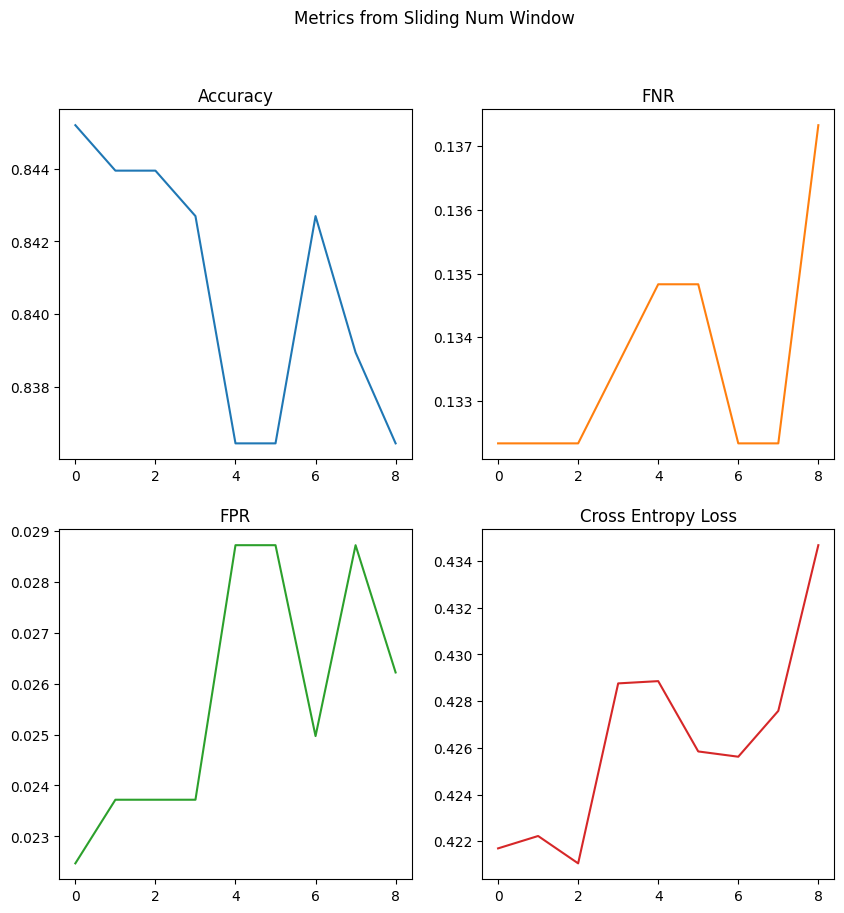

In [190]:
(num_window_accuracy_array, num_window_fpr_array,
    num_window_fnr_array, num_window_cross_entropy_loss_array) = run_experiment(
    method="noise", window_length=25, num_windows=range(3, 20, 3), num_params=25)

0


/var/folders/yw/hx45vt355w34n2w1ydcr2j7c0000gn/T/ipykernel_19044/3405463890.py:61: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  logits, torch.tensor(label, dtype=torch.long).unsqueeze(0))


100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
num_windows: 5
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800


/var/folders/yw/hx45vt355w34n2w1ydcr2j7c0000gn/T/ipykernel_19044/1023029901.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


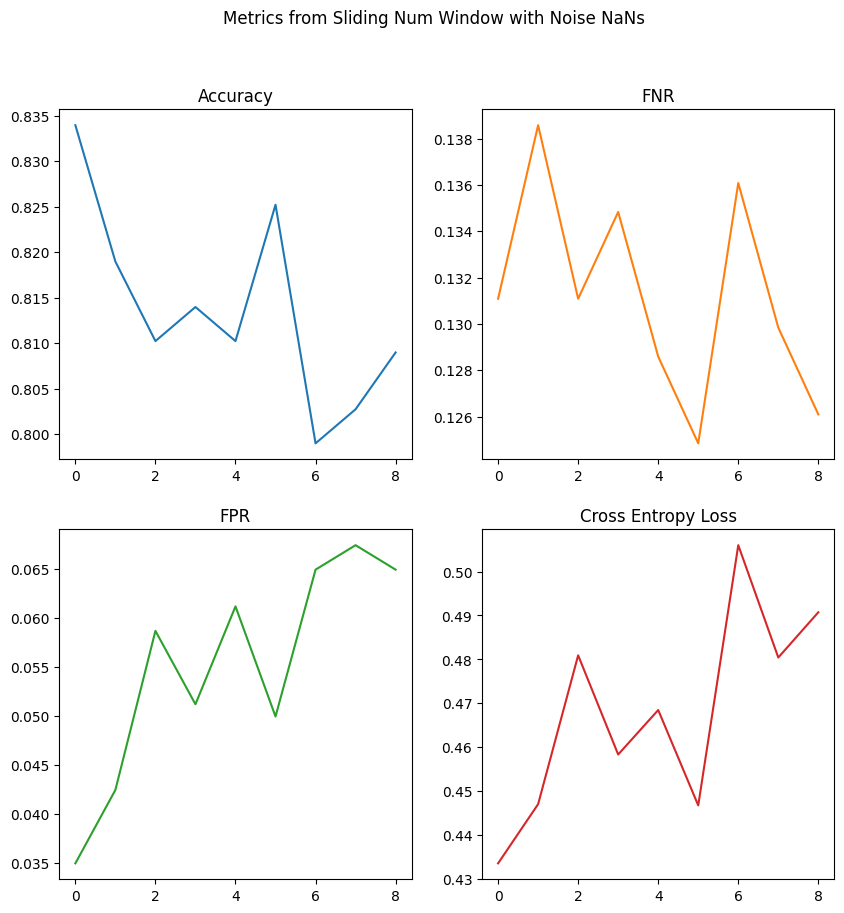

In [191]:
fig, axs = plot_metrics(accuracy_array=num_window_accuracy_array,
                        fnr_array=num_window_fnr_array,
                        fpr_array=num_window_fpr_array,
                        cross_entropy_loss_array=num_window_cross_entropy_loss_array,
                        plot_title="Metrics from Sliding Num Window with Noise NaNs")

fig.savefig("metrics_from_sliding_num_window_noise.png")
fig.show()

#### Params

In [176]:
(num_params_accuracy_array, num_params_fpr_array,
    num_params_fnr_array, num_params_cross_entropy_loss_array) = run_experiment(
    method="ffill", window_length=25, num_windows=10, num_params=range(13))

num_params: 0
0


/var/folders/yw/hx45vt355w34n2w1ydcr2j7c0000gn/T/ipykernel_19044/614755127.py:57: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  logits, torch.tensor(label, dtype=torch.long).unsqueeze(0))


100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
num_params: 2
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
num_params: 4
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
num_params: 6
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
num_params: 8
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
num_params: 10
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
num_params: 12
0
100
200
300
400
500
600
700
800


/var/folders/yw/hx45vt355w34n2w1ydcr2j7c0000gn/T/ipykernel_19044/1277932470.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


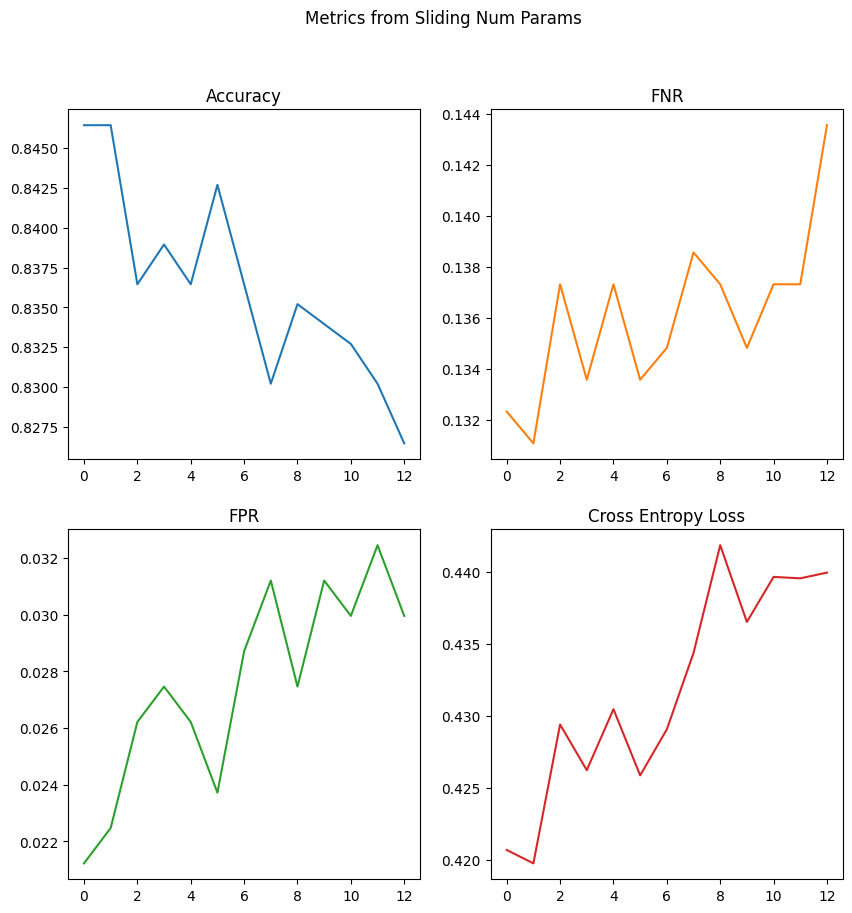

In [183]:
fig, axs = plot_metrics(accuracy_array=num_params_accuracy_array,
                        fnr_array=num_params_fnr_array,
                        fpr_array=num_params_fpr_array,
                        cross_entropy_loss_array=num_params_cross_entropy_loss_array,
                        plot_title="Metrics from Sliding Num Params")

fig.savefig("metrics_from_sliding_num_params.png")
fig.show()

In [193]:
(num_params_accuracy_array, num_params_fpr_array,
    num_params_fnr_array, num_params_cross_entropy_loss_array) = run_experiment(
    method="noise", window_length=25, num_windows=10, num_params=range(13))

num_params: 0
0


/var/folders/yw/hx45vt355w34n2w1ydcr2j7c0000gn/T/ipykernel_19044/3405463890.py:61: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  logits, torch.tensor(label, dtype=torch.long).unsqueeze(0))


100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
num_params: 2
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
num_params: 4
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
num_params: 6
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
num_params: 8
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
num_params: 10
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
num_params: 12
0
100
200
300
400
500
600
700
800


/var/folders/yw/hx45vt355w34n2w1ydcr2j7c0000gn/T/ipykernel_19044/2469603563.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


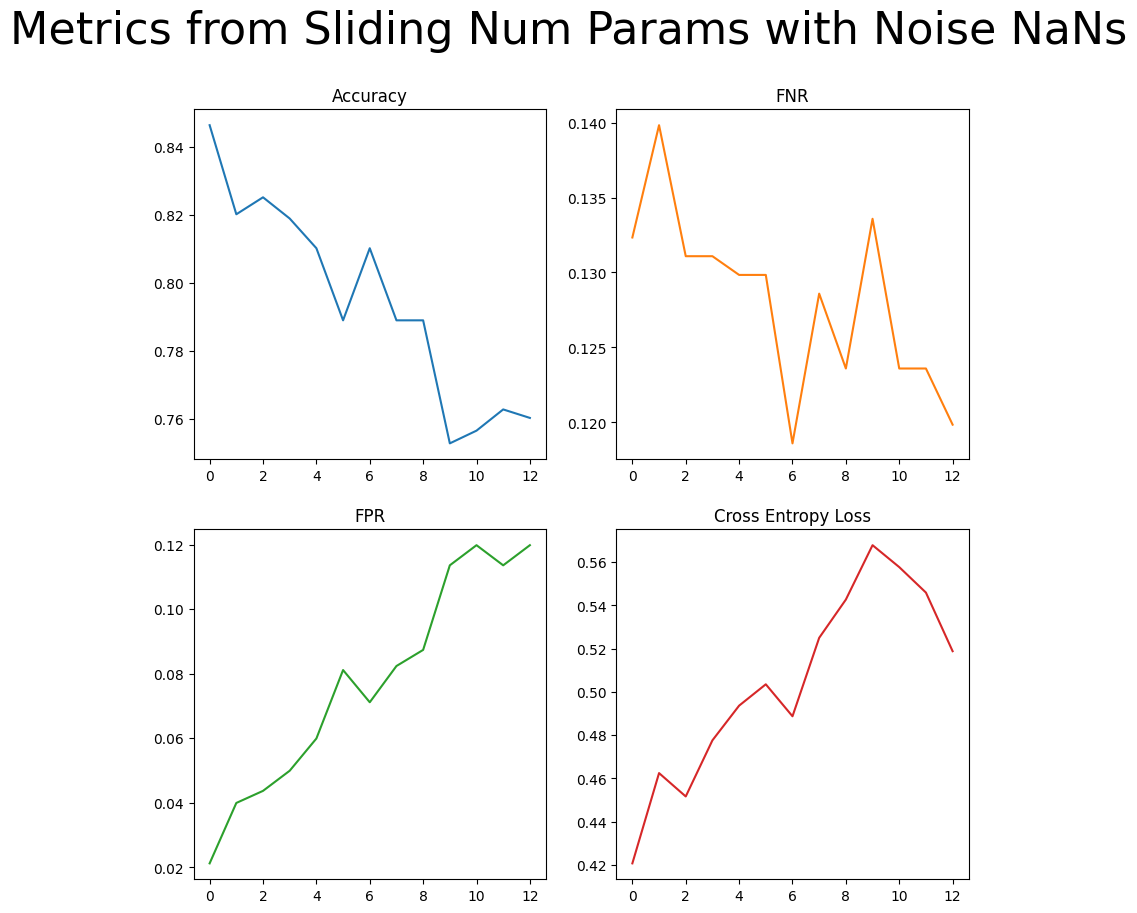

In [195]:
fig, axs = plot_metrics(accuracy_array=num_params_accuracy_array,
                        fnr_array=num_params_fnr_array,
                        fpr_array=num_params_fpr_array,
                        cross_entropy_loss_array=num_params_cross_entropy_loss_array,
                        plot_title="Metrics from Sliding Num Params with Noise NaNs")

fig.savefig("metrics_from_sliding_num_params_noise.png")
fig.show()

### Window Length

In [196]:
(window_length_accuracy_array, window_length_fpr_array,
    window_length_fnr_array, window_length_cross_entropy_loss_array) = run_experiment(
    method="ffill", window_length=range(2, 1000, 100), num_windows=10, num_params=5)

window_length: 2
0


/var/folders/yw/hx45vt355w34n2w1ydcr2j7c0000gn/T/ipykernel_19044/3405463890.py:61: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  logits, torch.tensor(label, dtype=torch.long).unsqueeze(0))


100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800


/var/folders/yw/hx45vt355w34n2w1ydcr2j7c0000gn/T/ipykernel_19044/190535251.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


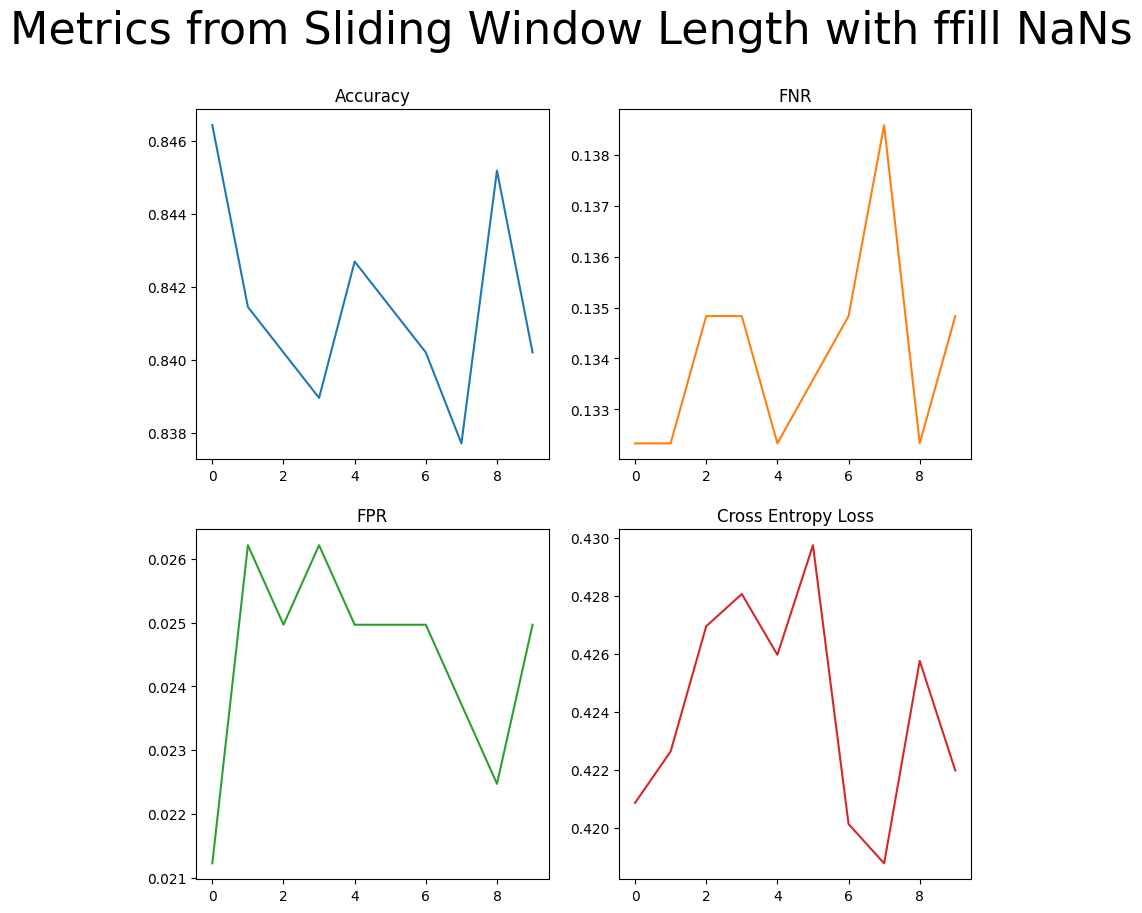

In [197]:
fig, axs = plot_metrics(accuracy_array=window_length_accuracy_array,
                        fnr_array=window_length_fnr_array,
                        fpr_array=window_length_fpr_array,
                        cross_entropy_loss_array=window_length_cross_entropy_loss_array,
                        plot_title="Metrics from Sliding Window Length with ffill NaNs")

fig.savefig("metrics_from_sliding_window_length_ffill.png")
fig.show()

In [198]:
(window_length_accuracy_array, window_length_fpr_array,
    window_length_fnr_array, window_length_cross_entropy_loss_array) = run_experiment(
    method="noise", window_length=range(2, 1000, 100), num_windows=10, num_params=5)

window_length: 2
0


/var/folders/yw/hx45vt355w34n2w1ydcr2j7c0000gn/T/ipykernel_19044/3405463890.py:61: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  logits, torch.tensor(label, dtype=torch.long).unsqueeze(0))


100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800
0
100
200
300
400
500
600
700
800


/var/folders/yw/hx45vt355w34n2w1ydcr2j7c0000gn/T/ipykernel_19044/1049387447.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


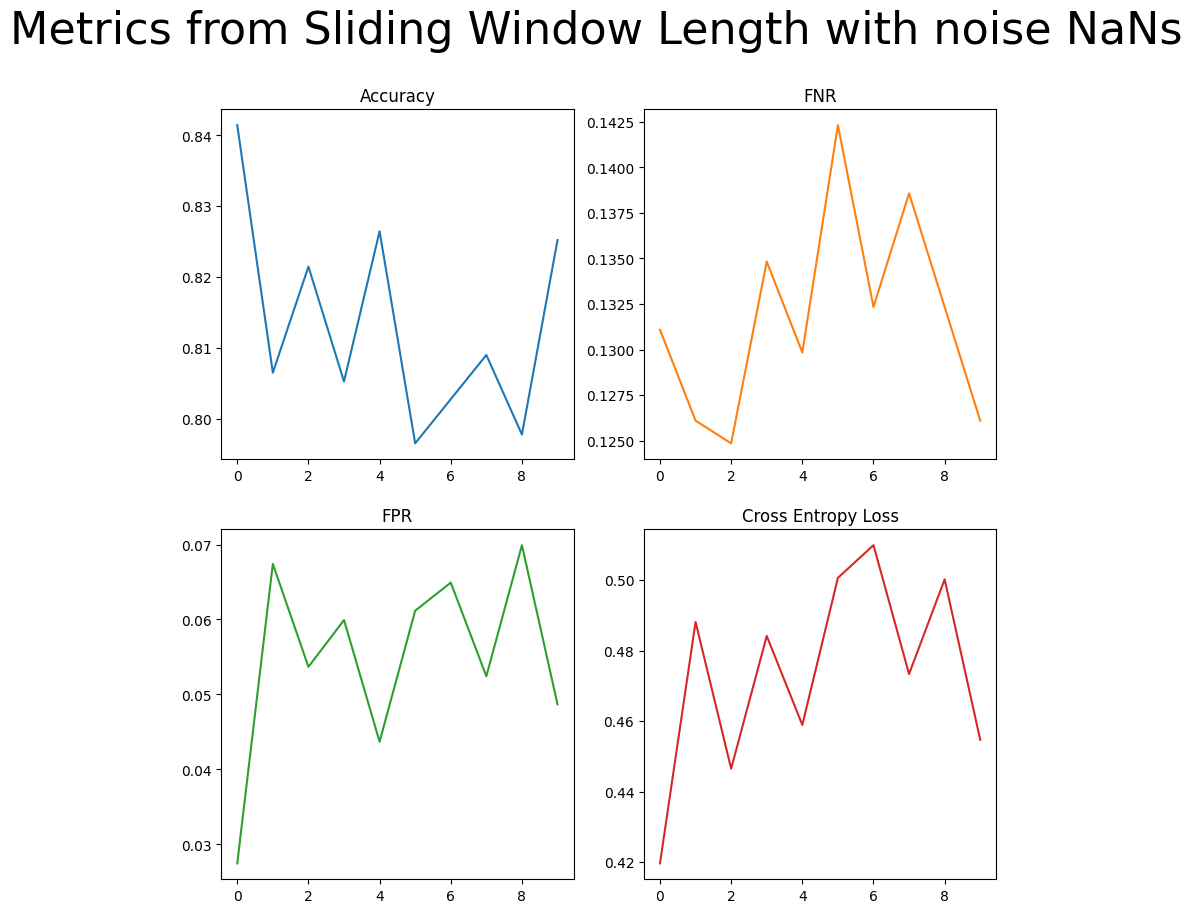

In [199]:
fig, axs = plot_metrics(accuracy_array=window_length_accuracy_array,
                        fnr_array=window_length_fnr_array,
                        fpr_array=window_length_fpr_array,
                        cross_entropy_loss_array=window_length_cross_entropy_loss_array,
                        plot_title="Metrics from Sliding Window Length with noise NaNs")

fig.savefig("metrics_from_sliding_window_length_noise.png")
fig.show()

In [206]:
(window_length_accuracy_array, window_length_fpr_array,
 window_length_fnr_array, window_length_cross_entropy_loss_array) = (
    run_experiment(method="ffill", window_length=range(2, 1000, 100),
                   num_windows=5, num_params=5))

0


/var/folders/yw/hx45vt355w34n2w1ydcr2j7c0000gn/T/ipykernel_19044/3405463890.py:61: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  logits, torch.tensor(label, dtype=torch.long).unsqueeze(0))


100


KeyboardInterrupt: 